In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

#### Load the Dataset

In [2]:
# Load the dataset from an Excel file
file_path = Path(r"G:\College\University of Montana\Semester 4\Capstone"
                 r"\MSBA-Capstone-Riley-ORorke\data\Source_Capstone_Data.xlsx")

# Read the Excel file into a Pandas DataFrame
df = pd.read_excel(file_path, header=0)  # Ensure headers are recognized

#### Data Preprocessing

In [3]:
# Define columns to keep
COLUMNS_TO_KEEP = ["C.[EntryTimestamp]", "C.[DataValue]"]
df = df[COLUMNS_TO_KEEP]

# Convert measurement values to numeric
df["C.[DataValue]"] = pd.to_numeric(df["C.[DataValue]"], errors="coerce")

# Convert timestamps to datetime and set as index
df["C.[EntryTimestamp]"] = pd.to_datetime(df["C.[EntryTimestamp]"], errors="coerce")
df = df.dropna(subset=["C.[EntryTimestamp]"]).sort_values(by="C.[EntryTimestamp]").reset_index(drop=True)
df.set_index("C.[EntryTimestamp]", inplace=True)

# Handle missing values (Interpolation preferred over dropping for ARIMA)
df["C.[DataValue]"] = df["C.[DataValue]"].interpolate(method="linear")

# Outlier Removal Using IQR
Q1 = df["C.[DataValue]"].quantile(0.25)
Q3 = df["C.[DataValue]"].quantile(0.75)
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
df = df[(df["C.[DataValue]"] >= lower_bound) & (df["C.[DataValue]"] <= upper_bound)]



#### ACF / PACF Analysis

ADF Statistic: -4.8277
p-value: 0.0000
The series is stationary.


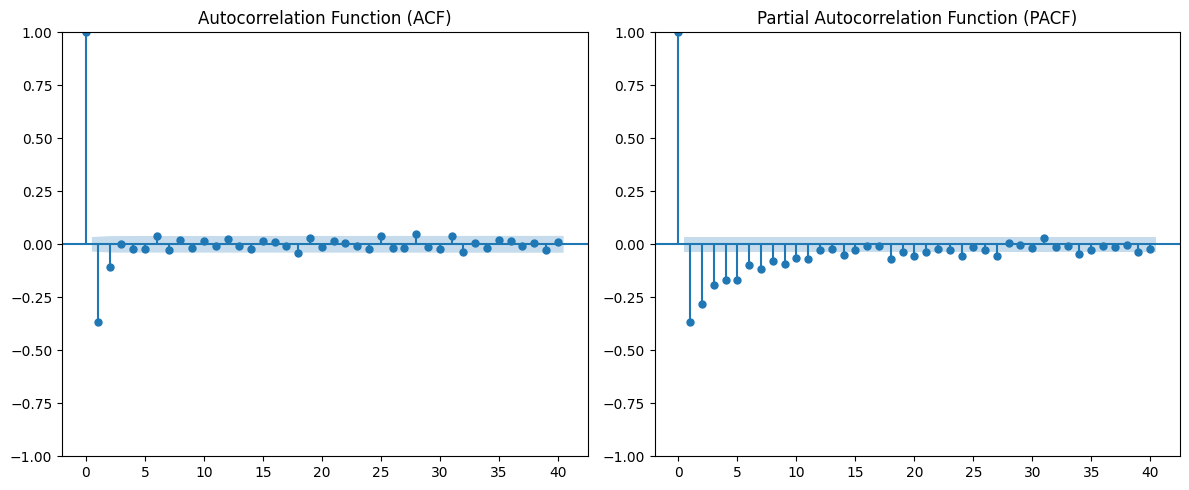

In [4]:
# Perform Augmented Dickey-Fuller Test to check stationarity
adf_test = adfuller(df["C.[DataValue]"])
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")
if adf_test[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing is needed.")

# Plot ACF and PACF to determine ARIMA (p, d, q) parameters
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df["C.[DataValue]"].diff().dropna(), ax=axes[0], lags=40)
axes[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df["C.[DataValue]"].diff().dropna(), ax=axes[1], lags=40)
axes[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()


#### Train Model

In [5]:
# Define target variable
y = df["C.[DataValue]"]

# Define ARIMA order (p, d, q) - Tuned based on ACF/PACF analysis
P_VALUE, D_VALUE, Q_VALUE = 1, 0, 1  # Update as needed

# Fit ARIMA model
model = ARIMA(y, order=(P_VALUE, D_VALUE, Q_VALUE))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Generate predictions
FORECAST_STEPS = 10  # Predict next 10 cycles
y_pred = model_fit.forecast(steps=FORECAST_STEPS)

# Convert predictions into a DataFrame
future_dates = pd.date_range(
    start=df.index[-1], periods=FORECAST_STEPS + 1, freq="D"
)[1:]
predictions_df = pd.DataFrame({"date": future_dates, "predicted_bore_size": y_pred})

# Display predictions
display(predictions_df)


C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

                               SARIMAX Results                                
Dep. Variable:          C.[DataValue]   No. Observations:                 3248
Model:                 ARIMA(1, 0, 1)   Log Likelihood                7986.111
Date:                Sun, 27 Apr 2025   AIC                         -15964.222
Time:                        12:01:22   BIC                         -15939.878
Sample:                             0   HQIC                        -15955.501
                               - 3248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.9582      0.002   4.83e+04      0.000      79.955      79.961
ar.L1          0.9392      0.009    106.125      0.000       0.922       0.957
ma.L1         -0.7219      0.014    -50.444      0.0

C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,date,predicted_bore_size
3248,2025-02-22 11:02:44.283,79.989210
3249,2025-02-23 11:02:44.283,79.987326
3250,2025-02-24 11:02:44.283,79.985557
3251,2025-02-25 11:02:44.283,79.983896
3252,2025-02-26 11:02:44.283,79.982335
3253,2025-02-27 11:02:44.283,79.980870
3254,2025-02-28 11:02:44.283,79.979493
3255,2025-03-01 11:02:44.283,79.978200
3256,2025-03-02 11:02:44.283,79.976986
3257,2025-03-03 11:02:44.283,79.975845


#### Model Evaluation

Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.0154
Mean Squared Error (MSE): 0.0004
Root Mean Squared Error (RMSE): 0.0207


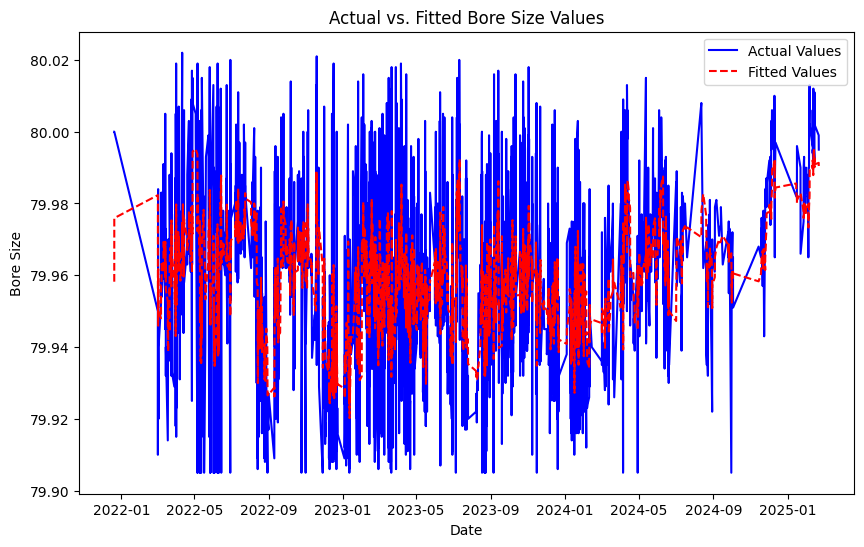

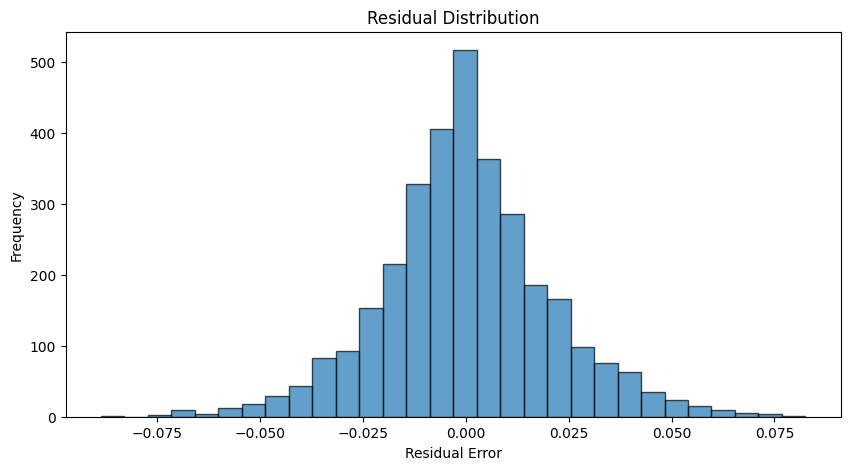

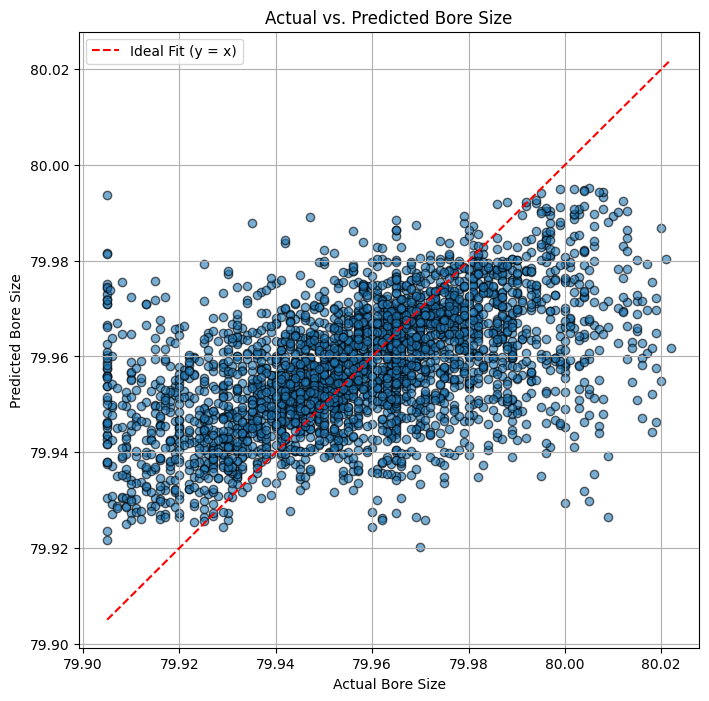

In [6]:
# Generate predictions for the same time range
y_pred = model_fit.fittedvalues

# Calculate evaluation metrics
mae = mean_absolute_error(df["C.[DataValue]"], y_pred)
mse = mean_squared_error(df["C.[DataValue]"], y_pred)
rmse = np.sqrt(mse)

# Print the results
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["C.[DataValue]"], label="Actual Values", color="blue")
plt.plot(df.index, y_pred, label="Fitted Values", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Bore Size")
plt.title("Actual vs. Fitted Bore Size Values")
plt.legend()
plt.show()

# Residual Analysis
residuals = df["C.[DataValue]"] - y_pred
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(df["C.[DataValue]"], y_pred, alpha=0.6, edgecolor="k")
# Plot ideal fit line (y=x)
min_val = min(df["C.[DataValue]"].min(), y_pred.min())
max_val = max(df["C.[DataValue]"].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (y = x)')
plt.xlabel("Actual Bore Size")
plt.ylabel("Predicted Bore Size")
plt.title("Actual vs. Predicted Bore Size")
plt.legend()
plt.grid(True)
plt.show()



#### Predict Future Wear

In [7]:
# Define the number of future cycles to predict
FUTURE_CYCLES = 10  # Adjust as needed

# Generate future timestamps
future_dates = pd.date_range(
    start=df.index[-1], periods=FUTURE_CYCLES + 1, freq="D"
)[1:]

# Predict future bore sizes using the ARIMA model
future_predictions = model_fit.forecast(steps=FUTURE_CYCLES)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({
    "date": future_dates,
    "predicted_bore_size": future_predictions
})

# Compute bore size changes over time
future_df["bore_size_change"] = future_df["predicted_bore_size"].diff().fillna(0)

# Define wear classification function
def classify_wear(change):
    """Classify bore wear based on the size change."""
    if change < 0.001:
        return "Normal Wear"
    if 0.001 <= change < 0.005:
        return "Moderate Wear"
    return "Critical Wear"

# Assign wear labels to future cycles
future_df["predicted_wear_stage"] = future_df["bore_size_change"].apply(classify_wear)

C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Riley_26\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Finalized Dataset

In [8]:
# Ensure consistency in dataset structure
df["predicted_bore_size"] = np.nan  # Set actual cycles to NaN in prediction column
df["predicted_wear_stage"] = np.nan

# Align column names before concatenation
future_df = future_df.set_index("Date").reset_index()

# Reset index in the actual dataset
df = df.reset_index()

# Combine actual and future data
final_df = pd.concat([df, future_df], ignore_index=True)

# Define output path
output_path = (
    r"G:\College\University of Montana\Semester 4\Capstone\"
    r"MSBA-Capstone-Riley-ORorke\data\arima_future_wear_predictions.xlsx"
)

# Save the predicted dataset to an Excel file
final_df.to_excel(output_path, index=False, engine="openpyxl")

# Display the final dataset
display(final_df)


SyntaxError: unterminated string literal (detected at line 16) (2502826684.py, line 16)